<h1>Comparison of Markov Chain Orders in Multi-Touch Attribution</h1>

The purpose of this notebook is to demonstrate different approaches in order estimation of Markov chain models. Modeling a dynamic systme such as customer journey analyses by Markov chains always requires an assumption on the order of the Markov chain. The order in Markov chain govern how much history is needed when evaluating a transition probability from one state into another. In first-order Markov chains, the transition probability is independent of previous history and only depends on the current state. In higher-order Markov chains, previous states play a role in determining transition probabilities. Order of a Markov chain will decide how far it is needed to look back at a customer journey given the current state to determine transition probabilities to future states.

## 1. Introduction <a name="se:intro"></a>

In higher order Markov chains, transition probabilities depend on the information prior to current state. The definition of `state` remains similar to first-order Markov chains which are described in [Multi-Touch Attribution with First-Order Markov Chains](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_First-order.html) solution. What changes in higher-order Markov chains are transition probabilities that consider previous `state` visitis in addition to the current state. In particular, in a first-order Markov chain, the probability of visiting state $j$ from state $i$ at time $t+1$ was goverened by the following conditional probability:

$$ P(i\rightarrow j):= P\big(S_{t+1} = j \big| S_{t} = i\big)$$,

whereas in, for example, a 2nd-order Markov chain, the same transition probability will be governed by:

$$ P(i\rightarrow j):= P\big(S_{t+1} = j \big| S_{t} = i, S_{t-1} = k\big)$$,

where $k$ is the state of the system at time $t-1$. The Markov property seems to be violated with this new definition because the transition probability is not memoryless and depends on previous history. However, a new state definition can resolve such violation. In this format, a state variable stores two steps of the customer journey where

$$ P(ki\rightarrow ij): = P\big(S_{t+1} = ij \big| S_{t} = ki\big)$$.

In multi-touch attribution settings, customer journeys through different channels can be modeled via a Markov chain where different channels construct the state space of the Markov model. For a first-order model, `state` of the Markov chain model will be equivalent to each `channel`. For higher-order Markov chains, the `state` variable stores two consecutive channels of each journey.

For example, in the following customer journey,

*journey1*: NATURAL SEARCH --> PAID SEARCH --> DISPLAY --> CONVERSION

Markov states that are visited by a customer are: `NATURAL SEARCH | PAID SEARCH`, `PAID SEARCH | DISPLAY`, and `DISPLAY | CONVERSION`. Similar to first-order case, attribution is evaluated by removal effects where a `state` removal is equivalent to removal of certain steps from the Markov chains. Attribution of a `channel` in this approach will be the sum of all state attributions where one of the steps was equal to that channel. 



## 2. Read-in sample data base <a name="se:data"></a>

A sample data base is provided which consists of `601776` customer identifier keys and the customer journeys to conversion or loss. Customer journeys are created from raw customer interactions (clicks, impressions, etc.) where individual interactions are grouped by an customer identifer key (e.g., cookie id), sorted by a timestamp (e.g., time of interaction) and joined together. For more details, refer to [Data Transformation](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Data%20Transformations/index.html) section of [Customer Journey Analytics](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/index.html). The sample data set is investigated to see no duplicate values are present in customer IDs. **NOTE** that this data set assumes only a homogeneous set of consumers.

In [1]:
import os
import inspect
import pandas as pd
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(curr_dir)
path_df = pd.read_csv(os.path.join(parent_dir, 
                                   "../Data Transformations/raw data/customer_journey_sample_data.csv"), 
                      index_col = 0)
print(f'The data frame includes {list(path_df.columns)} columns \
and {len(path_df.PGM_FREQ_MEMBER_KEY.unique())} distinct rows')
path_df.head(5)

The data frame includes ['PGM_FREQ_MEMBER_KEY', 'CAM_DEV', 'CONVERSION'] columns and 601776 distinct rows


,PGM_FREQ_MEMBER_KEY,CAM_DEV,CONVERSION
0,-9223328556171841832,"['NATURAL SEARCH|DESKTOP', 'REFERRAL ENGINE|DE...",1
1,-9223242021294710602,"['NATURAL SEARCH|DESKTOP', 'PAID SEARCH|DESKTOP']",1
2,-9223227354203035958,['DIRECT|DESKTOP'],0
3,-9223216806413203389,"['DIRECT|DESKTOP', 'NATURAL SEARCH|DESKTOP']",1
4,-9223197902225736847,"['NATURAL SEARCH|DESKTOP', 'DIRECT|DESKTOP', '...",1


**Stiching customer journeys**: The current customery journey stored in `path_df.CAM_DEV` only include channel visits and do not have any starting or absorbing point. The following function, `add_start_absorbing_state_func` produces a complete journey for each customer path in `path_df` data frame.

In [2]:
def add_start_absorbing_state_func(conversion, path):
    import ast
    path = ast.literal_eval(path)
    if conversion == 0:
        return ['Start'] + path + ['LOSS']
    else: 
        return ['Start'] + path + ['CONVERSION']

In [3]:
path_df['FULL_PATH'] = path_df.apply(lambda x: add_start_absorbing_state_func(x['CONVERSION'], x['CAM_DEV']), axis = 1)

**Dimension Reduction**: To simply the analysis and ease the computation effort, some of the states in the `unique_state_lst` are grouped together into `OTHER`. <span style="color:blue">**NOTE** that by leaving the `other_state_lst` list empty, the following Markov chain analyses will consider all the original states.</span> To further reduce dimensionality and to ease computation of transition probabilities device information is dropped from channels and recurrent transitions from and to the same channel are collapsed into a single channel visit. These operations are carried out by `remove_desktop_mobile`, `drop_recurring_channels`, and `reduce_states` functions below.

In [4]:
def remove_desktop_mobile(path):
    liststring = [l.replace('|DESKTOP', '').replace('|MOBILE', '') for l in path]
    return liststring

In [5]:
def drop_recurring_channels(A):
    return [A[i] for i in range(len(A)) if (i==0) or A[i] != A[i-1]]

In [6]:
def reduce_states(path, other_state_lst):
    new_path = []
    for row in path:
        new_row = []
        for state in row:
            if state in other_state_lst:
                state = 'OTHER'
            new_row.append(state)
        new_path.append(new_row)
    return new_path

In [8]:
## remove device information (desktop & mobile) from channels
path_df['FULL_PATH'] = path_df.FULL_PATH.apply(remove_desktop_mobile)

## drop recurring transitions
path_df['FULL_PATH'] = path_df['FULL_PATH'].apply(drop_recurring_channels)

## reduce state list
## uncomment below to reduce the number of states
other_channel_lst = ['ECONFO AND PRE-ARRIVAL EMAIL', 
                     'OTHER',
                     'UNPAID REFERRER',
                     'TEST',
                     'B2B',
                     'RESLINK']
path_df.FULL_PATH = reduce_states(path_df.FULL_PATH, other_channel_lst)

## print the remaining unique channel list
unique_channel_lst = set(channel for path in path_df.FULL_PATH for channel in path)
unique_channel_lst = set(channel if channel not in other_channel_lst else 'OTHER' for channel in unique_channel_lst)
print(unique_channel_lst - set(['Start', 'CONVERSION', 'LOSS']))

{'OTHER', 'DIRECT', 'REFERRAL ENGINE', 'PAID SEARCH', 'AFFILIATE', 'SOCIAL MEDIA', 'NATURAL SEARCH', 'DISPLAY', 'EMAIL'}


## 3. Training the 1st-order Markov model <a name="se:markov-1"></a>

All the steps in training a first-order Markov model for the same data set is covered in **Section 3** of [Multi-Touch Attribution with First-Order Markov Chains](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_First-order.html) solution. Those steps are wrapped into a single `first_order_tpm_func` function which given a data set of customer journeys, produces a transition probability matrix (TPM) for a first-order Markov chain whose states are unique channels of all customer journeys. **NOTE** that, it is assumed that all journeys have a `Start` state at the begining of the journey and end in one of the two absorbing states of `CONVERSION` or `LOSS`.

The `first_order_tpm_func` is a similar solution wrapped into a functon for portability. In fact, the algorithm for any order of Markov chain remains roughly similar. First, potential state transitions are generated. For a first-order Markov chain, state transitions can be represented by a pair of channels, e.g., `(from_channel, to_channel)`. Then, all customery journey transitions are parsed to enumerate the frequency of each transition. The last step is to turn these frequencies into transition probabilities by dividing each frequency to the sum of all frequencies that share the same starting points. This will ensure that the sum of transition probabilities in the transition probability matrix adds up to `1`. Or, in other words, the probabilities of transitioning out of a state in a Markov chain should sum up to `1`.

Transitions between state $i\rightarrow j$ are governed by transition probability of $P(i\rightarrow j)$ which can be stated as a conditional probability of the form:

$$P(i\rightarrow j) = P\big(S_{t+1} = j \,\big|\, S_t = i\big)$$

In [131]:
def first_order_tpm_func(path_df, unique_channel_lst):
    import pandas as pd
    
    ## generate all potential transitions
    potential_transitions_lst = [(from_state, to_state) 
                                 for from_state in unique_channel_lst 
                                     for to_state in unique_channel_lst]
    transitions_freq_dict = dict.fromkeys(potential_transitions_lst, 0)
    
    #count the number of each transition in data
    for row in path_df.iterrows():
        full_path = row[1]['FULL_PATH']
        for idx, channel in enumerate(full_path):
            from_state = channel if channel in unique_channel_lst else 'OTHER'
            to_state = full_path[idx + 1] if full_path[idx + 1] in unique_channel_lst else 'OTHER'
            transitions_freq_dict[(from_state, to_state)] += 1
            if to_state in ['CONVERSION', 'LOSS']:
                break
                
    ## convert the dictionary into data fram and add frq, from_state, and to_state columns
    transitions_freq_df = pd.DataFrame.from_dict(transitions_freq_dict, orient = 'index', columns = ['freq'])
    transitions_freq_df.reset_index(inplace = True)
    transitions_freq_df.rename(columns = {'index': 'transitions'}, inplace = True)
    transitions_freq_df[['from_state', 'to_state']] = transitions_freq_df.transitions.tolist()
    ## order columns for nicer output
    transitions_freq_df = transitions_freq_df[['from_state', 'to_state', 'transitions', 'freq']]
    
    ## evalauate transition probabilities by dividing the frequencey 
    transitions_freq_df['prob'] = transitions_freq_df['freq'] / \
                                  transitions_freq_df.groupby(['from_state'])['freq'].transform('sum')
    transitions_freq_df = transitions_freq_df[transitions_freq_df.prob != 0]
    
    return transitions_freq_df

## 4. Training the 2nd-order Markov model <a name="se:markov-2"></a>

As discussed in [**Section 1**](#se:intro), higher-order Markov chain store more customer journey history into their state variable. In a 2nd-order Markov chain, transition from state to another, depends on the previous state of the system as well. To conserve the Markovian property, the state definition will be changed to incorporate pairs of state at each time. For example, a transition in a 2nd-order Markov chain can be representated by two pairs of channels where `(prior_channel, current_channel) --> (current_channel, post_channel)`. Since `current_channel` will always be the same between these two pairs, a 2nd-order Markov chain transition can be denoted by a tuple of three elements, e.g., `(prior_channel, current_channel, post_channel)`.

The `second_order_tpm_func` function below modifies the first-order algorithm a little bit to accomodate new state definitions. However, the algorithm steps remain exactly the same. Potential transitions are generated. All transitions are then enumerated in each customer journey to create a frequency matrix and eventually a transition probability matrix. Transition probabilities in a 2nd-order Markov chain are conditioned on the current and the previous channel visits.

$$P(k\rightarrow i\rightarrow j) = P\big(S_{t+1} = j\,\big |\, S_{t} = i, S_{t-1} = k\big)$$

The Markovian property is preserved by changing the state defition in the following way:

$$P(k\rightarrow i\rightarrow j) = P\big(S_{t+1} = (i\rightarrow j)\,\big |\, S_{t} = (k\rightarrow i)\big)$$

where transition probabilities still only depend on the current state.

In [128]:
def second_order_tpm_func(path_df, unique_channel_lst):
    
    ## generate all potential transitions
    potential_transitions_lst = [(from_state_1, from_state_2, to_state) 
                                 for from_state_1 in unique_channel_lst 
                                     for from_state_2 in unique_channel_lst 
                                         for to_state in unique_channel_lst]
    ## do not need to take out impossible states like (s1, Start, s2)

    transitions_freq_dict = dict.fromkeys(potential_transitions_lst, 0)
    
    ## count the number of each transition in data
    for row in path_df.iterrows():
        full_path = row[1]['FULL_PATH']
        for idx, state in enumerate(full_path):
            from_state_2 = state if state in unique_channel_lst else 'OTHER'
            to_state = full_path[idx + 1] if full_path[idx + 1] in unique_channel_lst else 'OTHER'
            if idx == 0:
                transitions_freq_dict[('Start', from_state_2, to_state)] += 1 
                continue
            from_state_1 = full_path[idx - 1] if full_path[idx - 1] in unique_channel_lst else 'OTHER'
            transitions_freq_dict[(from_state_1, from_state_2, to_state)] += 1            
            if to_state in ['CONVERSION', 'LOSS']:
                break
                
    ## convert the dictionary into data fram and add frq, from_state, and to_state columns
    transitions_freq_df = pd.DataFrame.from_dict(transitions_freq_dict, 
                                                 orient = 'index', 
                                                 columns = ['freq'])
    transitions_freq_df.reset_index(inplace = True)
    transitions_freq_df.rename(columns = {'index': 'transitions'}, inplace = True)
    transitions_freq_df[['prior', 'current', 'post']] = transitions_freq_df.transitions.tolist()
    
    ## reformat state definitions to match the formal definition of 2nd-order Markov chains
    transitions_freq_df['from_state'] = transitions_freq_df['prior'] + \
                                        ' | ' + \
                                        transitions_freq_df['current']
    transitions_freq_df['to_state'] = transitions_freq_df['current'] + \
                                      ' | ' + \
                                      transitions_freq_df['post']

    ## exclude Start, LOSS, and CONVERSION from the same naming convention
    ## (s1, s2, loss) = loss, (s1, s2, conversion) = conversion
    transitions_freq_df['to_state'][transitions_freq_df['post'] == 'LOSS'] = 'LOSS'
    transitions_freq_df['to_state'][transitions_freq_df['post'] == 'CONVERSION'] = 'CONVERSION'
    transitions_freq_df['to_state'][transitions_freq_df['current'] == 'LOSS'] = 'LOSS'
    transitions_freq_df['to_state'][transitions_freq_df['current'] == 'CONVERSION'] = 'CONVERSION'

    transitions_freq_df['from_state'][transitions_freq_df['current'] == 'LOSS'] = 'LOSS'
    transitions_freq_df['from_state'][transitions_freq_df['current'] == 'CONVERSION'] = 'CONVERSION'
    transitions_freq_df['from_state'][transitions_freq_df['prior'] == 'LOSS'] = 'LOSS'
    transitions_freq_df['from_state'][transitions_freq_df['prior'] == 'CONVERSION'] = 'CONVERSION'
    
    ## evalauate transition probabilities by dividing the frequencey
    transitions_freq_df = transitions_freq_df.groupby(['from_state', 'to_state'])['freq'].agg('sum').reset_index()
    transitions_freq_df['prob'] = transitions_freq_df['freq'] / \
                                  transitions_freq_df.groupby(['from_state'])['freq'].transform('sum')
    return transitions_freq_df

## 5. Training the 3rd-order Markov model <a name="se:markov-3"></a>

Extending the logic of 2nd-order Markov chains to highr-order is straightforward. This time, transitions within the Markov chain require more knowledge of the history. To accomodate that and conserve the Markovian property, the state definition expands from pairs of channels to tuples of three channels where a transition can be represented by `(predecessor, prior, current) --> (prior, current, post)`. Similar to the 2nd-order, the same transition can also be denoted by a tuple of four channels `prior` and `current` channel visits will remain the same in both states of the transition. Therefore, `(predecessor, prior, current, post)` would suffice to describe a transition in a 3rd-order Markov chain.

The `third_order_tpm_func` below, extends the Markov chain tranining logic to the third order. All the steps previously discussed in training of first- and second-order Markov chain model will remain the same. The conditional probabilities of transition probabilities also have a straightforward extension for a 3rd-order Markov chain.

$$P(t\rightarrow k\rightarrow i\rightarrow j) = P\big(S_{t+1} = j\,\big |\, S_{t} = i, S_{t-1} = k, S_{t-2} = t\big)$$

where the Markovian property requires the state definition to change to

$$P(t\rightarrow k\rightarrow i\rightarrow j) = P\big(S_{t+1} = (k\rightarrow i\rightarrow j)\,\big |\, S_{t} = (t\rightarrow k\rightarrow i)\big)$$

In [1]:
def v(path_df, unique_channel_lst):
    ## generate all potential transitions
    potential_transitions_lst = [(from_state_1, from_state_2, from_state_3, to_state) 
                                 for from_state_1 in unique_channel_lst 
                                     for from_state_2 in unique_channel_lst 
                                         for from_state_3 in unique_channel_lst 
                                             for to_state in unique_channel_lst]
    
    transitions_freq_dict = dict.fromkeys(potential_transitions_lst, 0)
    
    ## count the number of each transition in data
    for row in path_df.iterrows():
        full_path = row[1]['FULL_PATH']
        for idx, state in enumerate(full_path):
            from_state_3 = state if state in unique_channel_lst else 'OTHER'
            to_state = full_path[idx + 1] if full_path[idx + 1] in unique_channel_lst else 'OTHER'
            if idx == 0:
                transitions_freq_dict[('Start', 'Start', from_state_3, to_state)] += 1
                continue
            if idx == 1:
                from_state_2 = full_path[idx - 1] if full_path[idx - 1] in unique_channel_lst else 'OTHER'
                transitions_freq_dict[('Start', from_state_2, from_state_3, to_state)] += 1 
                if to_state in ['CONVERSION', 'LOSS']:
                    break
                continue
            from_state_2 = full_path[idx - 1] if full_path[idx - 1] in unique_channel_lst else 'OTHER'
            from_state_1 = full_path[idx - 2] if full_path[idx - 2] in unique_channel_lst else 'OTHER'
            transitions_freq_dict[(from_state_1, from_state_2, from_state_3, to_state)] += 1
            if to_state in ['CONVERSION', 'LOSS']:
                break
    
    ## convert the dictionary into data fram and add frq, from_state, and to_state columns
    transitions_freq_df = pd.DataFrame.from_dict(transitions_freq_dict, 
                                                 orient = 'index', 
                                                 columns = ['freq'])
    transitions_freq_df.reset_index(inplace = True)
    transitions_freq_df.rename(columns = {'index': 'transitions'}, inplace = True)
    
    transitions_freq_df[['prior2', 'prior1', 'current', 'post']] = transitions_freq_df.transitions.tolist()
    
    ## reformat state definitions to match the formal definition of 2nd-order Markov chains
    transitions_freq_df['from_state'] = transitions_freq_df['prior2'] + \
                                        ' | ' + \
                                        transitions_freq_df['prior1'] + \
                                        ' | ' + \
                                        transitions_freq_df['current']

    transitions_freq_df['to_state'] =   transitions_freq_df['prior1'] + \
                                        ' | ' + \
                                        transitions_freq_df['current'] + \
                                        ' | ' + \
                                        transitions_freq_df['post']
    
    ## exclude Start, LOSS, and CONVERSION from the same naming convention
    ### for example, (s1, s2, s3, loss) = loss, (s1, s2, s3, conversion) = conversion, (start, start, start, s2) = start
    transitions_freq_df.loc[transitions_freq_df['post'] == 'LOSS', 'to_state'] = 'LOSS'
    transitions_freq_df.loc[transitions_freq_df['post'] == 'CONVERSION', 'to_state'] = 'CONVERSION'
    transitions_freq_df.loc[transitions_freq_df['current'] == 'LOSS', 'to_state'] = 'LOSS'
    transitions_freq_df.loc[transitions_freq_df['current'] == 'CONVERSION', 'to_state'] = 'CONVERSION'
    transitions_freq_df.loc[transitions_freq_df['prior1'] == 'LOSS', 'to_state'] = 'LOSS'
    transitions_freq_df.loc[transitions_freq_df['prior1'] == 'CONVERSION', 'to_state'] = 'CONVERSION'

    transitions_freq_df.loc[transitions_freq_df['current'] == 'LOSS', 'from_state'] = 'LOSS'
    transitions_freq_df.loc[transitions_freq_df['current'] == 'CONVERSION', 'from_state'] = 'CONVERSION'
    transitions_freq_df.loc[transitions_freq_df['prior1'] == 'LOSS', 'from_state'] = 'LOSS'
    transitions_freq_df.loc[transitions_freq_df['prior1'] == 'CONVERSION', 'from_state'] = 'CONVERSION'
    transitions_freq_df.loc[transitions_freq_df['prior2'] == 'LOSS', 'from_state'] = 'LOSS'
    transitions_freq_df.loc[transitions_freq_df['prior2']== 'CONVERSION', 'from_state'] = 'CONVERSION'
    
    ## evalauate transition probabilities by dividing the frequencey
    transitions_freq_df = transitions_freq_df.groupby(['from_state', 'to_state'])['freq'].agg('sum').reset_index()
    transitions_freq_df['prob'] = transitions_freq_df['freq'] / \
                                  transitions_freq_df.groupby(['from_state'])['freq'].transform('sum')
    
    return transitions_freq_df

In the followin code chunk, the customer journey data set of `path_df` is used to train 1st-, 2nd-, and 3rd-order Markov chains utilizing `first_order_tpm_func`, `second_order_tpm_func`, and `third_order_tpm_func` functions. Each function produces a transition probability data frame which is converted into a proper matrix. Absorbing probabilities of `LOSS` and `CONVERSION` states are added manually.

In [132]:
import warnings
warnings.filterwarnings('ignore')
base_conversion_rate = sum(path_df['CONVERSION']) / path_df.shape[0]

print('First-order Markov training ...')
freq1_df = first_order_tpm_func(path_df, unique_channel_lst)
## creating transition probability matrix
tpm1_df = pd.pivot_table(freq1_df.fillna(0), 
                         index = 'from_state',
                         columns = 'to_state',
                         values = 'prob').fillna(0)
tpm1_df.loc[tpm1_df.index == 'LOSS', 'LOSS'] = 1
tpm1_df.loc[tpm1_df.index == 'CONVERSION', 'CONVERSION'] = 1

print('Second-order Markov training ...')
freq2_df = second_order_tpm_func(path_df, unique_channel_lst)
tpm2_df = pd.pivot_table(freq2_df.fillna(0), 
                         index = 'from_state',
                         columns = 'to_state',
                         values = 'prob').fillna(0)
tpm2_df.loc[tpm2_df.index == 'LOSS', 'LOSS'] = 1
tpm2_df.loc[tpm2_df.index == 'CONVERSION', 'CONVERSION'] = 1

print('Third-order Markov training ...')
freq3_df = third_order_tpm_func(path_df, unique_channel_lst)
tpm3_df = pd.pivot_table(freq3_df.fillna(0), 
                         index = 'from_state',
                         columns = 'to_state',
                         values = 'prob').fillna(0)
tpm3_df.loc[tpm3_df.index == 'LOSS', 'LOSS'] = 1
tpm3_df.loc[tpm3_df.index == 'CONVERSION', 'CONVERSION'] = 1

First-order Markov training ...
Second-order Markov training ...
Third-order Markov training ...


## 6. Attribution of higher-order Markov chains <a name="se:attribution"></a>

Attribution of higher-order Markov chains are evaluated in a similar process to first-order chains. A channel attribution in a Markov chain model is evaluated as its removal effect in the chain. Removing a channel from a Markov chain will change the overall probability of conversion from the `Start` state. This change is typically considered as channel attribution. For a thorough review of the algorithm to calculate a channel's removal effect, refer to the [Multi-Touch Attribution with First-Order Markov Chains](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Methodologies/Markov%20Chains/MTA_Markov%20chains_First-order.html) solution where each step of the algorithm is described in detail in **Section 4**.

The `removal_effects` function below, implements the exact approach with few modifications. While in the first-order Markov chain, removal of a channel was equivalent to removal of one state, this is not the case for higher-order chains. For example, channel $i$ will appear in multiple states of the Markov chain such as $(k\rightarrow i), (i\rightarrow k), (j\rightarrow i), (i\rightarrow j), \ldots$. Therefore, removing one channel requires the algorithm to remove multiple states of the Markov chain at the same time, recalibrate the transition probability matrix, and evaluate the probability to conversion to measure its change from the baseline before removal of the channel.

In [133]:
def removal_effects(tpm_df, base_conversion_rate, unique_channel_lst, start_state):
    import numpy as np
    from tqdm import tqdm

    RE_dict = {}
    channels = [channel for channel in unique_channel_lst if channel not in ['Start', 'LOSS', 'CONVERSION']]
    for channel in channels:
        cols_to_rem = [col for col in tpm_df.columns if channel in col]
        removal_df = tpm_df.drop(cols_to_rem, axis = 1).drop(cols_to_rem, axis = 0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['LOSS'] += null_pct
            removal_df.loc['LOSS']['LOSS'] = 1.0
        R = removal_df[['LOSS', 'CONVERSION']].drop(['LOSS', 'CONVERSION'], axis = 0)
        T = removal_df.drop(['LOSS', 'CONVERSION'], axis = 1).drop(['LOSS', 'CONVERSION'], axis = 0)
        I = np.identity(len(T.columns))
        P = np.dot(np.linalg.inv(I - T), np.asarray(R))
        new_CR = pd.DataFrame(P, index = R.index)[[1]].loc[start_state].values[0]
        RE = 1 - new_CR / base_conversion_rate
        RE_dict[channel] = RE
    re_sum = np.sum(list(RE_dict.values()))
    new_RE_dict = {k: v / re_sum for k, v in RE_dict.items()}
    return RE_dict, new_RE_dict

The code chunck below utilizes the function above to calculate the removal effects (attributions) for each channel for 1st-, 2nd-, and 3rd-order Markov chains. Raw attribution numbers are turned into relative percentages and are bundled up in the `attributions_df` data frame for visualization and comparison.

In [181]:
attributions_df = pd.DataFrame()

## calculating attribution of first-order Markov chain
start_state = 'Start'
removal_effects_dict, normalized_removal_effects_dict = removal_effects(tpm1_df, 
                                                                        base_conversion_rate, 
                                                                        unique_channel_lst, 
                                                                        start_state)
total_conversions = sum(path.count('CONVERSION') for path in path_df['FULL_PATH'].tolist())
new_attributions = {k:v  * total_conversions for k, v in normalized_removal_effects_dict.items()}
new_attributions = pd.DataFrame.from_dict(new_attributions, orient = 'index', columns = ['attribution'])
new_attributions.reset_index(inplace = True)
new_attributions.rename(columns = {'index': 'channel'}, inplace = True)
new_attributions.sort_values(by = 'attribution', ascending = False, inplace = True)
new_attributions.reset_index(drop = True, inplace = True)
new_attributions['per'] = new_attributions.attribution / new_attributions.attribution.sum()
new_attributions['Order'] = '1st-order'
attributions_df = attributions_df.append(new_attributions)

## calculating attribution of second-order Markov chain
start_state = 'Start | Start'
removal_effects_dict, normalized_removal_effects_dict = removal_effects(tpm2_df, 
                                                                        base_conversion_rate, 
                                                                        unique_channel_lst, 
                                                                        start_state)
total_conversions = sum(path.count('CONVERSION') for path in path_df['FULL_PATH'].tolist())
new_attributions = {k:v  * total_conversions for k, v in normalized_removal_effects_dict.items()}
new_attributions = pd.DataFrame.from_dict(new_attributions, orient = 'index', columns = ['attribution'])
new_attributions.reset_index(inplace = True)
new_attributions.rename(columns = {'index': 'channel'}, inplace = True)
new_attributions.sort_values(by = 'attribution', ascending = False, inplace = True)
new_attributions.reset_index(drop = True, inplace = True)
new_attributions['per'] = new_attributions.attribution / new_attributions.attribution.sum()
new_attributions['Order'] = '2nd-order'
attributions_df = attributions_df.append(new_attributions)

## calculating attribution of third-order Markov chain
start_state = 'Start | Start | Start'
removal_effects_dict, normalized_removal_effects_dict = removal_effects(tpm3_df, 
                                                                        base_conversion_rate, 
                                                                        unique_channel_lst, 
                                                                        start_state)
total_conversions = sum(path.count('CONVERSION') for path in path_df['FULL_PATH'].tolist())
new_attributions = {k:v  * total_conversions for k, v in normalized_removal_effects_dict.items()}
new_attributions = pd.DataFrame.from_dict(new_attributions, orient = 'index', columns = ['attribution'])
new_attributions.reset_index(inplace = True)
new_attributions.rename(columns = {'index': 'channel'}, inplace = True)
new_attributions.sort_values(by = 'attribution', ascending = False, inplace = True)
new_attributions.reset_index(drop = True, inplace = True)
new_attributions['per'] = new_attributions.attribution / new_attributions.attribution.sum()
new_attributions['Order'] = '3rd-order'
attributions_df = attributions_df.append(new_attributions)

In [182]:
attributions_df = attributions_df.reset_index(drop = True)
attributions_df

,channel,attribution,per,Order
0,DIRECT,74827.140718,0.333144,1st-order
1,NATURAL SEARCH,63046.832910,0.280696,1st-order
2,OTHER,24798.923053,0.110409,1st-order
3,EMAIL,21402.537897,0.095288,1st-order
4,PAID SEARCH,21015.715783,0.093566,1st-order
5,REFERRAL ENGINE,8658.339461,0.038548,1st-order
6,AFFILIATE,7096.532604,0.031595,1st-order
7,DISPLAY,2974.462626,0.013243,1st-order
8,SOCIAL MEDIA,788.514947,0.003511,1st-order
9,DIRECT,75367.947633,0.335552,2nd-order


### 6.1 Comparing higher-order attribution  <a name="sse:attribution-results"></a>

Different orders of Markov chain will result in different attribution distribution among channels. To compare the three model in this notebook, channel attributions of `attributions_df` are compared by a grouped bar plot. Notice that while the relative performance of channels follows the same pattern in general for this sample data set, higher-order Markov chain assign considerably more attribution to `NATURAL SEARCH` compared to the first-order model.

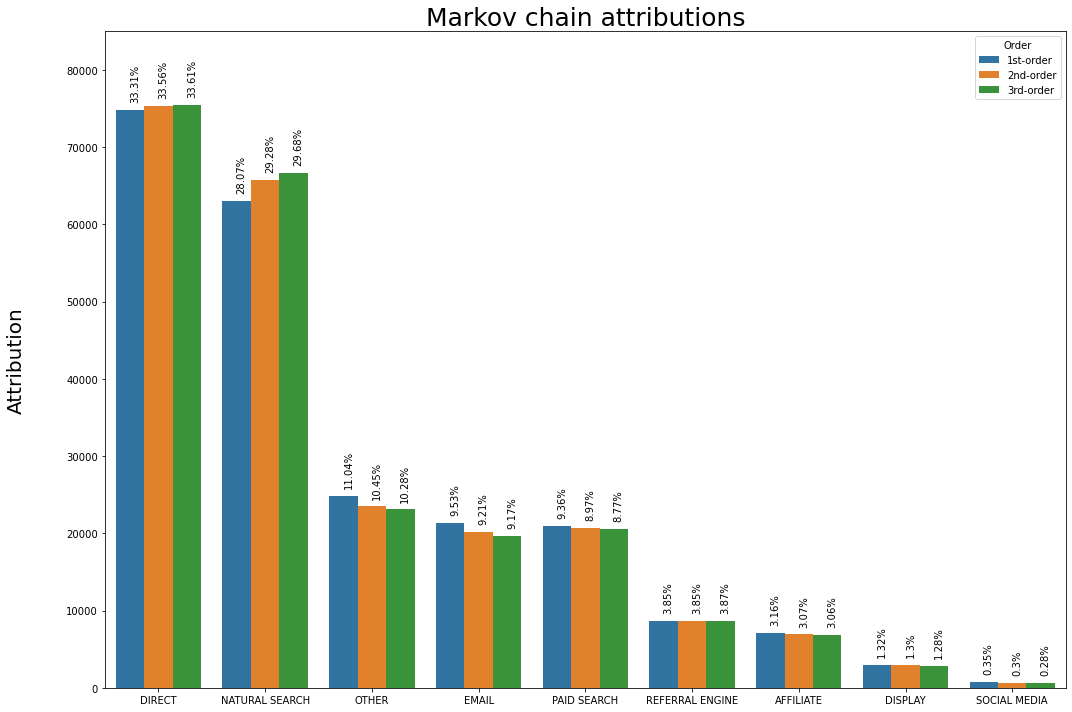

In [217]:
fig, ax = plt.subplots(figsize = (15, 10))

g = sns.barplot(x = "channel",
            y = "attribution", 
            hue = "Order", 
            data = attributions_df, 
            ci = None)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., 
            p.get_height() + 1000, 
            str(round(attributions_df.loc[attributions_df.index == i, 'per'].values[0] * 100, 2)) + '%', 
            fontsize = 10, 
            color = 'black',
            rotation = '90',
            ha = 'left', 
            va = 'bottom')
    
g.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha = 'center')
g.set_title('Markov chain attributions', fontsize = 25)
g.set_ylim(0, 85000)
plt.xlabel("", labelpad = 60, fontsize = 20)
plt.ylabel("Attribution", labelpad = 40, fontsize = 20)
plt.tight_layout()
plt.show()

## 7. Order estimation of Markov Chains <a name="se:order"></a>

While higher-order Markov chain allow for more flexibility in conditioning transition probabilities, and should result in more accurate attributions, they suffer from a complexity problem since the number of states grows exponentially as the order of the chain increases. To decide on an optimal trade-off between model accuracy and model complexity, AIC and BIC statistics have been used by different researchers. However, recently, it has been proved that for the purpose of order estimation of Markov chain, AIC is an inconsistent metric.

**It should be noted that this proof is limited to order estimation of Markov chains and the results do not hold true in comparing AIC and BIC metrics for other purposes**.

For Markov chain, a more generalized metric that can be transformed to AIC and BIC has been introduced for which conditions of consistency is known. The more general metric is referred to as **Efficient Determination Criterion (EDC)**. For more details, review the paper by **C.Y. Dorea et al (2015)** on [Comparing the Markov Order Estimators AIC, BIC and EDC](#https://link.springer.com/chapter/10.1007/978-94-017-7236-5_4).

### 7.1. Efficient Determination Criterion (EDC) <a name="sse:order-edc"></a>

EDC as a general form of both BIC and AIC metrics is given by 

$$\text{EDC} = -2\log L_m + \gamma(m) c_n$$

where $m$ denotes the order of Markov chain, $L_m$ is the likelihood, $\gamma(m)$ is an increasing function of $m$, and $c_n$ is a function of sample size $n$. Setting $\gamma(m)$ to $k$ and $c_n$ to $2$ where $k$ is the number of channels in a Markov chain will result in the classic AIC metric. To get the classic BIC, $\gamma(m)$ can be set to $k$ while $c_n$ should be equal to $\log n$.

It is proved that the conditions of consistency are

$$\lim_{n\to\infty} \frac{c_n}{n} \to 0 \qquad \lim_{n\to\infty} \frac{c_n}{\log\log n} \to\infty$$

by which it can be concluded that AIC is not a consistent metric for order estimation of Markov chains. Notice that classic BIC and AIC metric for Markov chains do not really take the order of Markov chains into consideration apart from the inclusion of the liklihood function. Some sources prefer to modify the $\gamma$ function for BIC metric to depend on the order as in $\gamma(m) = k^m (k-1)$. In the implementation below, in `get_bic_aic` function, both AIC and BIC metrics are calculated, however, BIC is using the modified definition of the $\gamma$ function.

In [231]:
def get_bic_aic(freq_df, unique_channel_lst, order): #input trans_prob_first(my_df)
    import numpy as np
    n = freq_df.freq.sum()
    order = order 
    #keep only non zero frequencies
    k = len(unique_channel_lst)
    #k = df.from_state.nunique()
    #keep only non zero frequencies
    freq_df = freq_df[freq_df['freq'] != 0]
    freq_df.reset_index(inplace = True, drop = True)
    #loglikehood
    ll = 0
    for i in range(freq_df.shape[0]):
        ll += freq_df['freq'][i]*np.log(freq_df['prob'][i])
    bic = -2*ll + ((k**order)*(k-1)*np.log(n))
    aic = -2*ll + 2**1
    print(f'BIC: {bic}, AIC:{aic}' )
    #print(f'LL: {ll}')
    return bic, aic

The following shows AIC and BIC metrics for different orders of Markov chain. According to both AIC and BIC metric, the 2nd-order Markov chain is the best model to describe customer journey transition probabilitis.

In [232]:
get_bic_aic(freq1_df, unique_channel_lst, 1)

BIC: 5832322.5716667995, AIC:5830426.352209581


(5832322.5716667995, 5830426.352209581)

In [233]:
get_bic_aic(freq2_df, unique_channel_lst, 2)

BIC: 5721868.41274137, AIC:5699091.779254748


(5721868.41274137, 5699091.779254748)

In [234]:
get_bic_aic(freq3_df, unique_channel_lst, 3)

BIC: 5924589.2043184275, AIC:5651247.602478962


(5924589.2043184275, 5651247.602478962)